<a href="https://colab.research.google.com/github/rinafb/FDR_compound/blob/main/Upworthy_data_BH.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import numpy as np
import scipy as sp
import matplotlib.pyplot as plt
import itertools
import math
import pandas as pd
np.random.seed(1234)

In [ ]:
## download Upworthy data
## dataset information: https://upworthy.natematias.com/

%%capture
!rm -rf *
!wget 'https://osf.io/download/vy8mj/' -q -O tmp.csv
df = pd.read_table('tmp.csv',delimiter=',')


In [ ]:
## merge entries that are the same headline
df = df[['clickability_test_id','headline','impressions','clicks']]
df = df.groupby(by=['clickability_test_id','headline'],as_index=False).sum()


In [ ]:
## check for numbers appearing in headline
number = '0123456789'
df['has_number'] = [any(p in s for p in number) \
                       for s in df['headline']]

## identify articles with >=1 headline in each category (number / no number)
counts = np.array(list(itertools.chain.from_iterable(
    df[['clickability_test_id','has_number']].groupby('clickability_test_id').\
    apply(lambda df_: [len(df_),int(df_['has_number'].sum())], \
    include_groups=False)))).reshape((-1,2))
IDs = df['clickability_test_id'].unique()[np.argwhere(\
    (counts[:,1]>0)&(counts[:,1]<counts[:,0])).T[0]]
IDs_inds = [ID in IDs for ID in df['clickability_test_id']]
m = len(IDs)

In [ ]:
## test function: fisher's exact test (one sided)

## apply test function to a matrix [[a0,b0],[a1,b1]]
## where a0,b0 = # of impressions,clicks for headlines with has_number=False
## and a1,b1 = # of impressions,clicks for headlines with has_number=True
test_fn = lambda mat: 1-sp.stats.fisher_exact(\
   np.array([[mat[0,0]-mat[0,1],mat[0,1]],[mat[1,0]-mat[1,1],mat[1,1]]]),\
                                            alternative='greater').pvalue

## test function on the data
test_fn_data = lambda df_: test_fn(df_[['impressions','clicks','has_number']].\
   groupby(['has_number']).sum().values)

## test function on the permuted data
def test_fn_data_perm(df_):
  inds = np.array(list(itertools.combinations(\
     np.arange(df_.shape[0]),df_['has_number'].sum())))
  inds_ = np.apply_along_axis(lambda inds1: \
                  np.setdiff1d(np.arange(df_.shape[0]),inds1), 1, inds)
  return np.array([ test_fn(np.array([
    [df_['impressions'].iloc[inds_[i]].sum(),df_['clicks'].iloc[inds_[i]].sum()],\
    [df_['impressions'].iloc[inds[i]].sum(),df_['clicks'].iloc[inds[i]].sum()]]))\
    for i in np.arange(inds.shape[0])] )

test_stat = df.iloc[IDs_inds].groupby(['clickability_test_id']).\
                     apply(test_fn_data,include_groups=False).values

test_stat_perm = df.iloc[IDs_inds].groupby(['clickability_test_id']).apply(\
  test_fn_data_perm,include_groups=False).tolist()


In [ ]:
## compute p-values and compound p-values
pval = np.array([(test_stat_perm[i] >= test_stat[i]).mean()\
                 for i in np.arange(m)])

get_compound_pval = lambda t: np.array([ (test_stat_perm[i] >= t).mean()\
        for i in np.arange(m)]).mean()

pval_compound = np.array([get_compound_pval(test_stat[i])\
                          for i in np.arange(m)])


## define BH procedure
BH = lambda p, alpha : np.max(np.argwhere(np.append([True],\
     np.array(np.sort(p) <= alpha*np.arange(1,len(p)+1)/len(p)))))

print('Number of articles = '+str(m))

print('# rejections for BH for pval / pval_compound:')
print('alpha = 0.1 : '+str(BH(pval,.1)) + ' / ' + str(BH(pval_compound,.1)))
print('alpha = 0.2 : '+str(BH(pval,.2)) + ' / ' + str(BH(pval_compound,.2)))
print('alpha = 0.5 : '+str(BH(pval,.5)) + ' / ' + str(BH(pval_compound,.5)))



Number of articles = 3893
# rejections for BH for pval / pval_compound:
alpha = 0.1 : 0 / 0
alpha = 0.2 : 0 / 0
alpha = 0.5 : 0 / 57


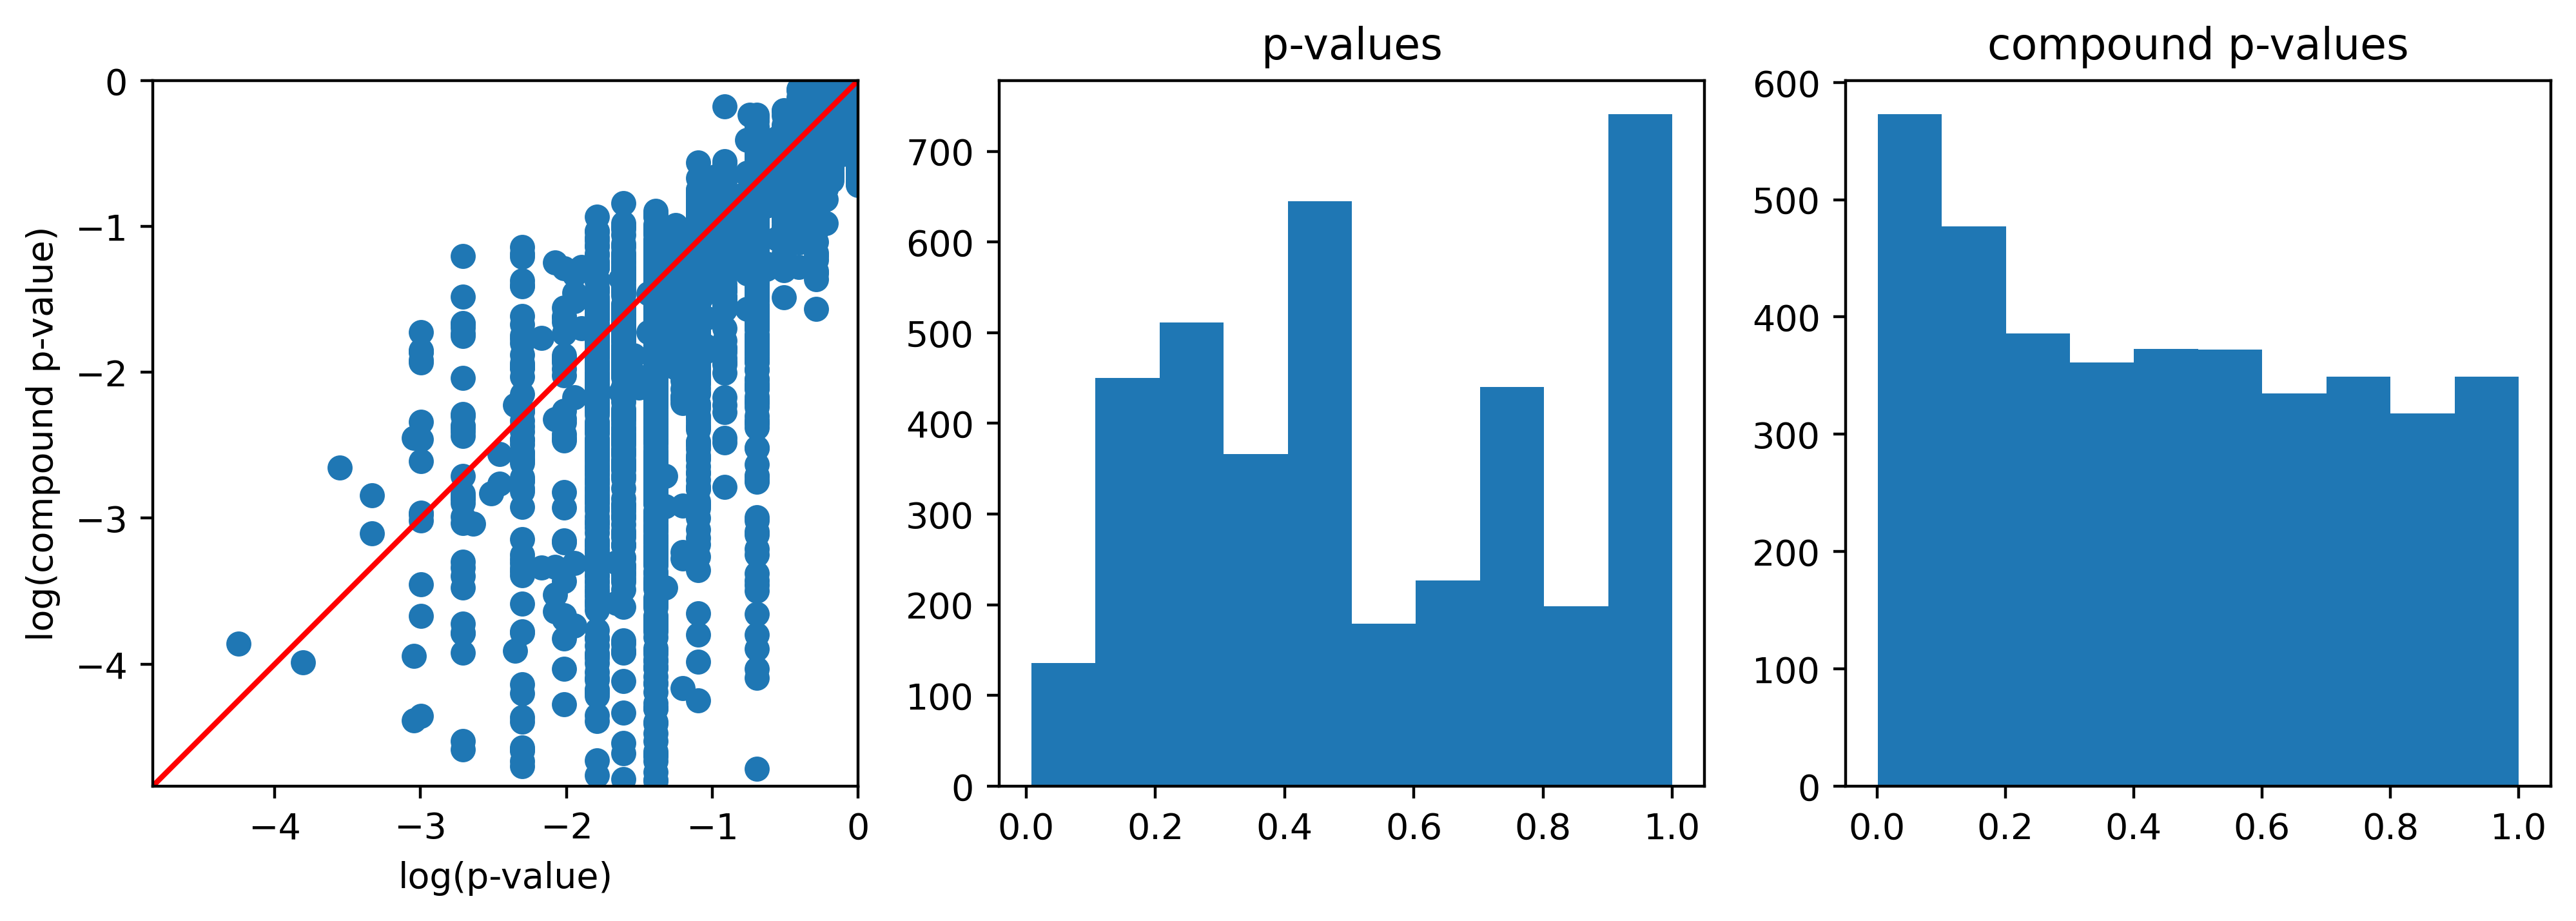

In [ ]:
## plot p-values & compound p-values

_, (ax1,ax2,ax3) = plt.subplots(1,3,figsize=(12,4),dpi=400)

ax1.scatter(np.log(pval),np.log(pval_compound))
pmin = np.amax([pval.min(),pval_compound.min()])
ax1.axline((np.log(pmin),np.log(pmin)),(0,0),color='r')
ax1.set_xlabel('log(p-value)')
ax1.set_ylabel('log(compound p-value)')
ax1.set_xlim((np.log(pmin),0))
ax1.set_ylim((np.log(pmin),0))
ax1.set_box_aspect(1)

ax2.hist(pval)
ax2.set_title('p-values')
ax2.set_box_aspect(1)
ax3.hist(pval_compound)
ax3.set_title('compound p-values')
ax3.set_box_aspect(1)

plt.show()


In [ ]:
## Repeat the experiment, but now we restrict to articles with > L many headlines

## compute p-values and compound p-values

L = 5
inds_ = np.argwhere((counts[:,1]>0)&(counts[:,1]<counts[:,0])).T[0]
inds = np.argwhere(counts[inds_,0]>L).T[0]
pval1 = np.array([(test_stat_perm[i] >= test_stat[i]).mean() for i in inds])

get_compound_pval1 = lambda t: np.array([ (test_stat_perm[i] >= t).mean()\
        for i in inds]).mean()

pval_compound1 = np.array([get_compound_pval1(test_stat[i]) for i in inds])


print('Number of articles = '+str(len(inds)))
print('(setting: keep articles with > '+str(L)+' headlines)')

print('# rejections for BH for pval / pval_compound:')
print('alpha = 0.1 : '+str(BH(pval1,.1)) + ' / ' + str(BH(pval_compound1,.1)))
print('alpha = 0.2 : '+str(BH(pval1,.2)) + ' / ' + str(BH(pval_compound1,.2)))
print('alpha = 0.5 : '+str(BH(pval1,.5)) + ' / ' + str(BH(pval_compound1,.5)))



Number of articles = 1025
(setting: keep articles with > 5 headlines)
# rejections for BH for pval / pval_compound:
alpha = 0.1 : 0 / 0
alpha = 0.2 : 0 / 11
alpha = 0.5 : 0 / 36


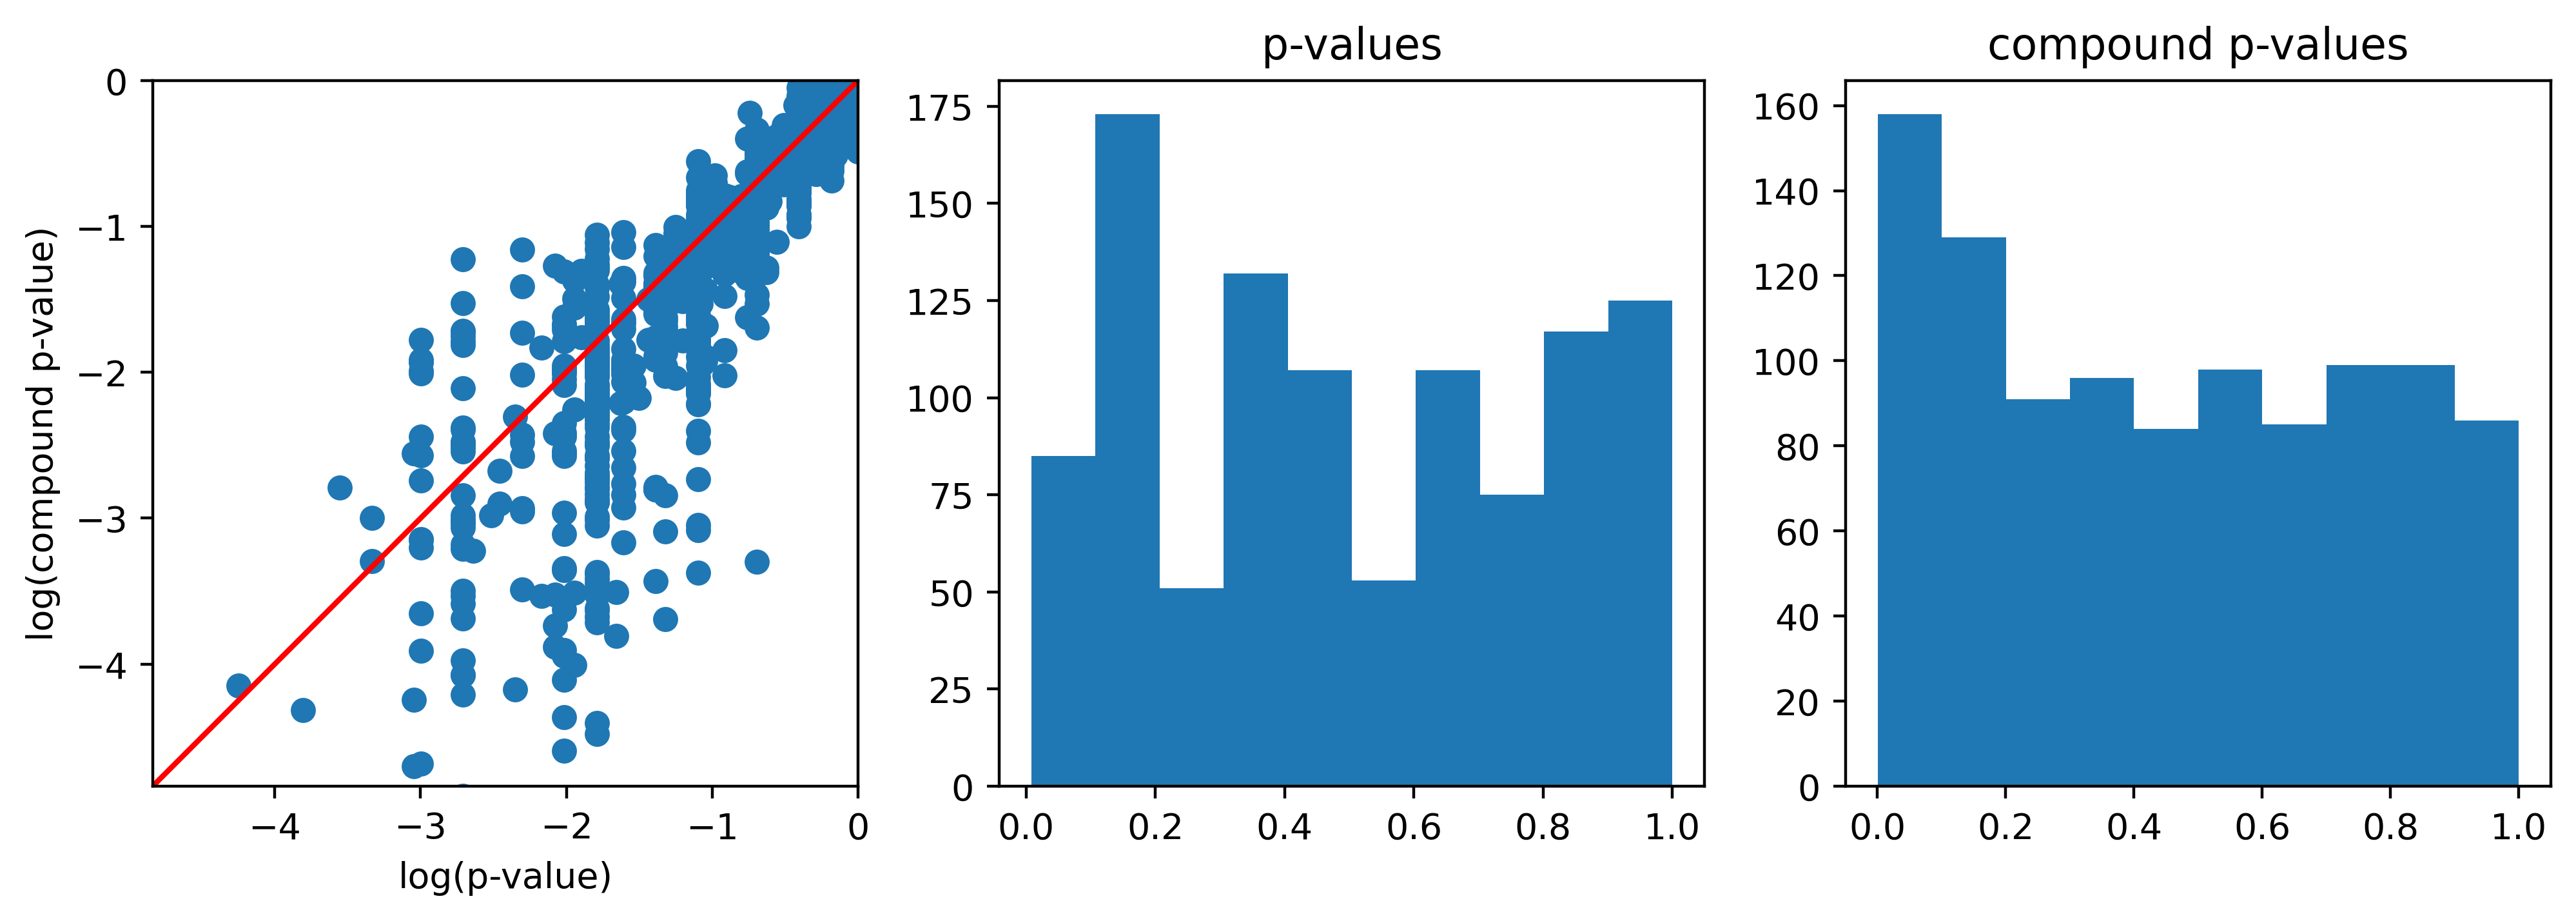

In [ ]:
## plot p-values & compound p-values

_, (ax1,ax2,ax3) = plt.subplots(1,3,figsize=(12,4),dpi=400)

ax1.scatter(np.log(pval1),np.log(pval_compound1))
pmin = np.amax([pval1.min(),pval_compound1.min()])
ax1.axline((np.log(pmin),np.log(pmin)),(0,0),color='r')
ax1.set_xlabel('log(p-value)')
ax1.set_ylabel('log(compound p-value)')
ax1.set_xlim((np.log(pmin),0))
ax1.set_ylim((np.log(pmin),0))
ax1.set_box_aspect(1)

ax2.hist(pval1)
ax2.set_title('p-values')
ax2.set_box_aspect(1)
ax3.hist(pval_compound1)
ax3.set_title('compound p-values')
ax3.set_box_aspect(1)

plt.show()
